In [250]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import yaml
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import datetime


In [241]:
# Load config file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set random seed
torch.manual_seed(config["seed"])

# Set device
device = torch.device(config["device"] 
                      if ((config["device"] == "mps" and torch.backends.mps.is_available()) 
                          or (config["device"] == "cuda" and torch.cuda.is_available())) else "cpu")

In [242]:
# Dataset mean and std normalization
data_mean = config["dataset"]["normalize"]["mean"]
data_std = config["dataset"]["normalize"]["std"]

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)
])

# Load datasets
dataset1 = datasets.MNIST(config["dataset"]["data_dir"], train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(config["dataset"]["data_dir"], train=False, transform=transform)

# Define data loaders
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=config["dataset"]["train_batch_size"], num_workers=config["dataset"]["num_workers"])
test_loader = torch.utils.data.DataLoader(
    dataset2, batch_size=config["dataset"]["test_batch_size"], num_workers=config["dataset"]["num_workers"])



In [243]:
# Calculate dataset mean & std (Optional, if normalization needs verification)
def calculate_dataset_stats(loader):
    mu = torch.zeros(1)
    sigma = torch.zeros(1)
    n_pixels = 0

    with torch.no_grad():
        for data, _ in loader:
            mu += data.sum(dim=(0, 2, 3))
            sigma += (data ** 2).sum(dim=(0, 2, 3))
            n_pixels += data.numel() // data.shape[1]

    mu /= n_pixels
    std = torch.sqrt(sigma / n_pixels - mu ** 2)
    return mu, std



In [244]:
# Define CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(**config["model"]["conv_layers"][0])
        self.bn1 = nn.BatchNorm2d(config["model"]["conv_layers"][0]["out_channels"])
        self.conv2 = nn.Conv2d(**config["model"]["conv_layers"][1])
        self.bn2 = nn.BatchNorm2d(config["model"]["conv_layers"][1]["out_channels"])
        self.fc1 = nn.Linear(**config["model"]["fc_layers"][0])
        self.fc2 = nn.Linear(**config["model"]["fc_layers"][1])

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)



In [246]:
# Training function with loss tracking
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    losses = []

    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for batch_idx, (data, target) in pbar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            losses.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            if batch_idx % log_interval == 0:
                pbar.set_description(f"Epoch {epoch} - Loss: {loss.item():.4f}")

    accuracy = 100. * correct / total
    return total_loss / len(train_loader), accuracy


In [247]:
# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy


In [252]:
# Compare different optimizers
optimizers = config["optimizer"]["optimizers"]
results = {}

for opt in optimizers:
    print(f"Training with {opt} optimizer...")

    # Initialize model
    model = Net().to(device)

    # Select optimizer
    learning_rate = config["optimizer"]["learning_rates"][opt]
    if opt == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=config["optimizer"]["momentum"])
    elif opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif opt == "Adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer choice")

    # Select learning rate scheduler
    scheduler_type = config["scheduler"]["type"]
    if scheduler_type == "StepLR":
        scheduler = StepLR(optimizer, step_size=config["scheduler"]["step_size"], gamma=config["scheduler"]["gamma"])
    elif scheduler_type == "ExponentialLR":
        scheduler = ExponentialLR(optimizer, gamma=config["scheduler"]["gamma"])
    else:
        raise ValueError("Invalid scheduler choice")

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Train the model
    for epoch in range(1, config["training"]["epochs"] + 1):
        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch, config["training"]["log_interval"])
        test_loss, test_acc = test(model, device, test_loader)
        scheduler.step()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Store results
    results[opt] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    }

    # Save model if enabled
    if config["logging"]["save_model"]:
        model_save_path = f"{config["logging"]["save_folder_path"]}/{opt.lower()}_mnist_model_{str(datetime.datetime.now())}.pth"
        if not os.path.exists(config["logging"]["save_folder_path"]):
            os.makedirs(config["logging"]["save_folder_path"])
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at {model_save_path}")

Training with Adam optimizer...


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Model saved at models/adam_mnist_model_2025-03-28 12:13:14.336766.pth
Training with Adadelta optimizer...


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Model saved at models/adadelta_mnist_model_2025-03-28 12:14:00.816528.pth
Training with SGD optimizer...


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Model saved at models/sgd_mnist_model_2025-03-28 12:14:44.332111.pth


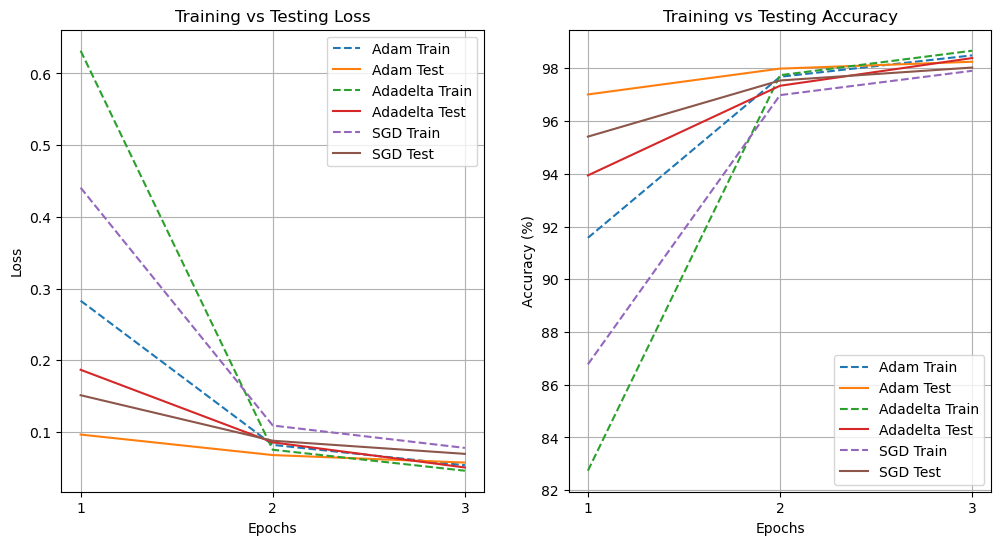

In [253]:
# Visualization of training performance
X = range(1, config["training"]["epochs"]+1)
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for opt in optimizers:
    plt.plot(X,results[opt]["train_losses"], label=f"{opt} Train", linestyle="dashed")
    plt.plot(X,results[opt]["test_losses"], label=f"{opt} Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid()
plt.xticks(X)

# Accuracy Plot
plt.subplot(1, 2, 2)
for opt in optimizers:
    plt.plot(X, results[opt]["train_accuracies"], label=f"{opt} Train", linestyle="dashed")
    plt.plot(X, results[opt]["test_accuracies"], label=f"{opt} Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.xticks(X)
plt.grid()

if(config["logging"]["visualize_training"]):
    plt.show()